In [94]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import distance
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import os
os.getcwd()

'/Users/artpark/Downloads'

In [95]:
file_path = '/Users/artpark/Downloads/ka-line-list-ihip.csv'
df_raw = pd.read_csv(file_path)
df_raw.columns

Index(['metadata.recordID', 'metadata.primaryDate', 'metadata.patientHealthID',
       'metadata.patientTransactionID', 'metadata.patientSpecimenID',
       'metadata.diseaseName', 'metadata.diseaseCode', 'demographics.age',
       'demographics.ageRange', 'demographics.gender', 'location.country.ID',
       'location.country.name', 'location.admin.hierarchy',
       'location.admin1.ID', 'location.admin1.name', 'location.admin2.ID',
       'location.admin2.name', 'location.admin3.ID', 'location.admin3.name',
       'location.admin4.ID', 'location.admin4.name', 'location.admin5.ID',
       'location.admin5.name', 'location.admin.coarseness',
       'location.geometry.latitude.provided',
       'location.geometry.longitude.provided', 'event.symptomOnset',
       'event.symptomOnsetDate', 'event.test',
       'event.test.sampleCollectionDate', 'event.test.testingLab',
       'event.test.test1.code', 'event.test.test1.name',
       'event.test.test1.result', 'event.test.test2.code',
     

In [123]:
df_lgd_path = '/Users/artpark/Downloads/lgd_code_name_state_dist_taluk.csv'
df_lgd = pd.read_csv(df_lgd_path)
kar_lgd = df_lgd[df_lgd['state_code']==29]
kar_lgd = kar_lgd.reset_index(drop=True)
kar_lgd

kar_lgd = kar_lgd.rename(columns={
    'estate_name_english': 'state',
    'district_name_english': 'district',
    'subdistrict_code':'taluk_code',
    'subdistrict_name_english': 'taluk'})
kar_lgd


df_lgd_village_path = '/Users/artpark/Documents/karnataka_villages_lgd_codes.csv'
lgd_village = pd.read_csv(df_lgd_village_path)
lgd_village.columns

Index(['district_code', 'district', 'taluk_code', 'taluk', 'village_code',
       'village', 'block_panchayat_code', 'block_panchayat',
       'gram_panchayat_code', 'gram_panchayat'],
      dtype='object')

In [97]:
columns_to_keep = ['metadata.primaryDate',
                  'event.test.resultDate',
                   'location.admin1.name',
                   'location.admin2.ID',
                   'location.admin2.name',
                   'location.admin3.ID',
                   'location.admin3.name',
                   'location.admin4.ID',
                   'location.admin4.name',
                   'location.admin5.ID',
                   'location.admin5.name',
                   'demographics.ageRange', 
                   'demographics.gender',
                   'event.test.test1.result',
                   'event.test.test2.result']

df_filt = df_raw[columns_to_keep]

df_filt['metadata.primaryDate'] = pd.to_datetime(df_filt['metadata.primaryDate']).dt.date
df_filt['event.test.resultDate'] = pd.to_datetime(df_filt['event.test.resultDate']).dt.date
df_filt = df_filt.dropna(subset=['metadata.primaryDate'])

start_date = df_filt['event.test.resultDate'].min()
end_date = df_filt['event.test.resultDate'].max()


df_filt['district_code'] = df_filt['location.admin2.ID'].str.extract('(\d+)')
df_filt['taluk_code'] = df_filt['location.admin3.ID'].str.extract('(\d+)')
df_filt['village_code'] = df_filt['location.admin5.ID'].str.extract('(\d+)')
df_filt


end_date 

/var/folders/gf/g2c78q9n67ldbc97nhdg_mmh0000gn/T/ipykernel_88145/767666658.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['metadata.primaryDate'] = pd.to_datetime(df_filt['metadata.primaryDate']).dt.date
/var/folders/gf/g2c78q9n67ldbc97nhdg_mmh0000gn/T/ipykernel_88145/767666658.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['event.test.resultDate'] = pd.to_datetime(df_filt['event.test.resultDate']).dt.date


datetime.date(2024, 7, 16)

In [208]:
# Define the specified date
specified_date = pd.to_datetime('2024-07-10').date()

# Filter rows where the date is greater than or equal to the specified date
date_filt = df_filt[df_filt['event.test.resultDate'] >= specified_date]
date_filt

date_filt['event.test.test1.result'] = date_filt['event.test.test1.result'].map({'Positive': 1, 'Unknown': 0})
date_filt['event.test.test2.result'] = date_filt['event.test.test2.result'].map({'Positive': 1, 'Unknown': 0})

date_filt['test_result'] = date_filt['event.test.test1.result'] + date_filt['event.test.test2.result']
date_filt

date_filt = date_filt.rename(columns={
    'event.test.resultDate': 'test_date',
    'location.admin1.name': 'state',
    'location.admin2.name': 'district',
    'location.admin3.name': 'taluk',
    'location.admin5.name': 'village',
    'demographics.ageRange':'age_range',
    'demographics.gender':'gender',
})

columns_to_keep = ['test_date',
                  'district_code',
                   'district',
                   'taluk_code',
                   'taluk',
                   'village_code',
                   'village',
                   'age_range',
                   'gender',
                   'test_result']

df = date_filt[columns_to_keep]
df= df.reset_index(drop=True)

df['district_code']=df['district_code'].astype(int)
df['taluk_code']=df['taluk_code'].astype(int)
df['village_code'] = df['village_code'].astype(int)
df['district'].unique()

total_cases_state = df['test_result'].sum()
total_cases_district = df.groupby(['district_code','district'])['test_result'].sum().reset_index()
total_cases_taluk = df.groupby(['district_code','district','taluk'])['test_result'].sum().reset_index()

df_bbmp = df[df['taluk']=='BBMP']
df_bbmp = df_bbmp.reset_index(drop=True)
total_cases_bbmp = df_bbmp ['test_result'].sum()
total_cases_taluk

total_cases_taluk = total_cases_taluk.rename(columns={
    'taluk': 'Taluk',
    'test_result': 'Cases',
})

total_cases_district = total_cases_district.rename(columns={
    'district': 'District',
    'test_result': 'Cases',
})
total_cases_district

/var/folders/gf/g2c78q9n67ldbc97nhdg_mmh0000gn/T/ipykernel_88145/3989483236.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_filt['event.test.test1.result'] = date_filt['event.test.test1.result'].map({'Positive': 1, 'Unknown': 0})
/var/folders/gf/g2c78q9n67ldbc97nhdg_mmh0000gn/T/ipykernel_88145/3989483236.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_filt['event.test.test2.result'] = date_filt['event.test.test2.result'].map({'Positive': 1, 'Unknown': 0})
/var/folders/gf/g2c78q9n67ldbc97nh

,district_code,District,Cases
0,524,Bagalkote,31
1,525,Bengaluru Urban,1594
2,526,Bengaluru Rural,13
3,527,Belagavi,49
4,528,Ballari,16
5,529,Bidar,36
6,530,Vijayapura,12
7,531,Chamarajanagara,8
8,532,Chikkamagaluru,12
9,533,Chitradurga,39


In [179]:
# df_dist = df[df['district']==select_dist]

df_dist = df.copy()
df_dist = df_dist.reset_index(drop=True)

columns_to_check = ['village_code','test_date']
df_dist = df_dist.dropna(subset=columns_to_check)
df_dist = df_dist[(df_dist['village_code'] != 0) &\
                  (df_dist['test_date'] != 0 )]

total_cases_without_village_state = total_cases_state - df_dist['test_result'].sum()
total_cases_without_village_district = df_dist.groupby(['district_code','district'])['test_result'].sum().reset_index()



village_counts = df_dist.groupby(['district_code','district','taluk_code','taluk','village_code']).size().reset_index(name='counts')
village_counts['label'] = village_counts['counts'].apply(lambda x: 'hotspot' if x > 1 else 'non-hotspot')

hotspots_df = village_counts[village_counts['counts'] > 1].copy()
non_hotspots_df = village_counts[village_counts['counts'] <= 1].copy()
hotspots_df['hotspot'] = 1
non_hotspots_df['non_hotspot'] = 1

,district_code,district,taluk_code,taluk,village_code,counts,label,non_hotspot
0,524,Bagalkote,5445,Mudhol,598553,1,non-hotspot,1
3,524,Bagalkote,5445,Mudhol,598570,1,non-hotspot,1
6,524,Bagalkote,5447,Bagalkot,598798,1,non-hotspot,1
7,524,Bagalkote,5447,Bagalkot,598844,1,non-hotspot,1
8,525,Bengaluru Urban,5542,Bengaluru North,938316,1,non-hotspot,1
...,...,...,...,...,...,...,...,...
434,635,Yadgir,7094,Gurumitkal,621361,1,non-hotspot,1
435,738,Vijayanagar,5496,Hadagalli,604589,1,non-hotspot,1
437,738,Vijayanagar,5496,Hadagalli,604598,1,non-hotspot,1
438,738,Vijayanagar,5496,Hadagalli,604599,1,non-hotspot,1


In [180]:
path_shape_files = '/Users/artpark/Documents/karnataka_shape_files_taluk_district/Village/Village.shp'
gdf = gpd.read_file(path_shape_files)
gdf_wgs84 = gdf.to_crs(epsg=4326)
gdf_wgs84['centroid'] = gdf_wgs84['geometry'].centroid
gdf_wgs84['centroid_longitude'] = gdf_wgs84['centroid'].x
gdf_wgs84['centroid_latitude'] = gdf_wgs84['centroid'].y


gdf_wgs84_a = pd.merge(gdf_wgs84,lgd_village, left_on='LGD_Villag',
                                 right_on='village_code',how='left') 

gdf_wgs84_a = gdf_wgs84_a.dropna(subset=['village_code'])
gdf_wgs84_a['district_code']=gdf_wgs84_a['district_code'].astype(int)
gdf_wgs84_a['taluk_code']=gdf_wgs84_a['taluk_code'].astype(int)
gdf_wgs84_a['village_code'] = gdf_wgs84_a['village_code'].astype(int)
gdf_wgs84_a = gdf_wgs84_a.reset_index(drop='True')


path_dist_shape_files = '/Users/artpark/Documents/karnataka_shape_files_taluk_district/District/District.shp'
gdf_dist = gpd.read_file(path_dist_shape_files)
gdf_dist_wgs84 = gdf_dist.to_crs(epsg=4326)
gdf_dist_wgs84

path_taluk_shape_files = '/Users/artpark/Documents/karnataka_shape_files_taluk_district/Taluk/Taluk.shp'
gdf_taluk = gpd.read_file(path_taluk_shape_files)
gdf_taluk_wgs84_tem = gdf_taluk.to_crs(epsg=4326)
gdf_taluk_wgs84 = pd.merge(gdf_taluk_wgs84_tem,kar_lgd, left_on='LGD_TalukC',
                                 right_on='taluk_code',how='left')


/var/folders/gf/g2c78q9n67ldbc97nhdg_mmh0000gn/T/ipykernel_88145/1284250495.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_wgs84['centroid'] = gdf_wgs84['geometry'].centroid


In [220]:
if not hotspots_df.empty:
    gdf_hotspots = pd.merge(hotspots_df, gdf_wgs84, left_on='village_code', right_on='LGD_Villag', how='inner')
if not non_hotspots_df.empty:
    gdf_non_hotspots = pd.merge(non_hotspots_df,gdf_wgs84, left_on='village_code', right_on='LGD_Villag', how='inner')
 
selected_columns = ['district',
                    'district_code',
                    'taluk',
                    'taluk_code',
                    'KGISVill_2',
                    'counts']

table_df = gdf_hotspots[selected_columns]

table_df = table_df.rename(columns={
    'district':'District',
    'taluk': 'Taluk',
    'KGISVill_2': 'Hotspot Villages',
    'counts': 'Cases in the Hotspot',
})

table_df

,District,district_code,Taluk,taluk_code,Hotspot Villages,Cases in the Hotspot
0,Bagalkote,524,Mudhol,5445,Malali,2
1,Bagalkote,524,Mudhol,5445,Utthura,2
2,Bagalkote,524,Mudhol,5445,Mantura,2
3,Bagalkote,524,Bagalkot,5447,Muranala,2
4,Bengaluru Urban,525,Bengaluru North,5542,Jalahalli,2
...,...,...,...,...,...,...
162,Chikkaballapura,630,Sidlaghatta,5599,Gudihalli,2
163,Chikkaballapura,630,Sidlaghatta,5599,Gudihalli,2
164,Chikkaballapura,630,Chintamani,5600,Kaiwara,2
165,Vijayanagar,738,Hadagalli,5496,Holalu,2


Tables saved successfully.


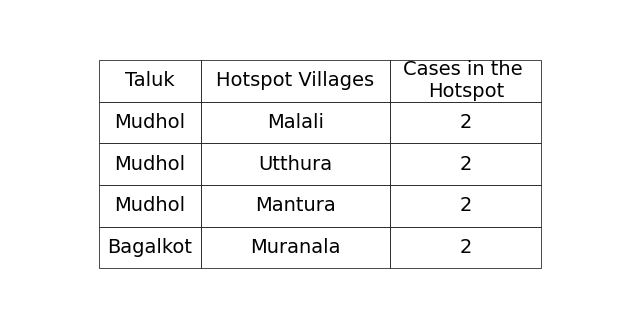

In [231]:
# Extract unique district names
# districts = table_df['District'].unique()

districts = ['Bagalkote']

# Iterate over each district
for district in districts:
    # Filter data for the current district
    table_df_dist = table_df[table_df['District'] == district]
    district_names = table_df_dist['District'].unique()[0]
    # total_cases_taluk_b = total_cases_taluk[total_cases_taluk['district'] == district]
    # table_filtered_taluk = total_cases_taluk_b.drop(columns=[District','taluk_code'])

    # Drop unnecessary columns
    table_df_dist_filtered = table_df_dist.drop(columns=['district_code','District','taluk_code'])

    table_df_dist_filtered = table_df_dist_filtered.rename(columns={
    'Taluk': 'Taluk',
    'Hotspot Villages': 'Hotspot Villages',
    'Cases in the Hotspot': 'Cases in the \nHotspot',
    })
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the size as needed

    # Hide the axes
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    # Create a table
    table = ax.table(cellText=table_df_dist_filtered.values,
                     colLabels=table_df_dist_filtered.columns,
                     cellLoc='center', loc='center')


    col_widths = [0.2, 0.2, 0.4]  # Adjust these values based on your data
    for i, width in enumerate(col_widths):
        table.auto_set_column_width(i)
        for j in range(len(table_df_dist_filtered) + 1):  # +1 for the header
            cell = table[j, i]
            cell.set_width(width)

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1, 2.5)  # Adjust scaling as needed

    # Adjust edge color and line width for columns
    cell_dict = table.get_celld()
    for (i, j), cell in cell_dict.items():
        cell.set_edgecolor('black')  # Set edge color for all cells
        cell.set_linewidth(0.5)  # Set line width for all cells

    # Set Sans-Serif font family for all cells
    for key, cell in table.get_celld().items():
        if key[0] == 0:  # Header row
            cell.set_text_props(fontfamily='sans-serif', weight='roman')
        else:  # Data rows
            cell.set_text_props(fontfamily='sans-serif')

    # Set plot title dynamically
    # plt.title(f'Dengue Hotspot for {district_names} District \n {from_date} to {to_date}',
    #           fontsize=16, pad=30)

    # # Save the figure as PNG without displaying it
    # save_fig = f'/Users/artpark/Downloads/karnataka_dengue_hotspots/{district}_hotspot_table.png'
    # plt.savefig(save_fig, dpi=300, bbox_inches='tight')

    # # Close the plot to free up memory
    # plt.close(fig)

print("Tables saved successfully.")

Tables saved successfully.


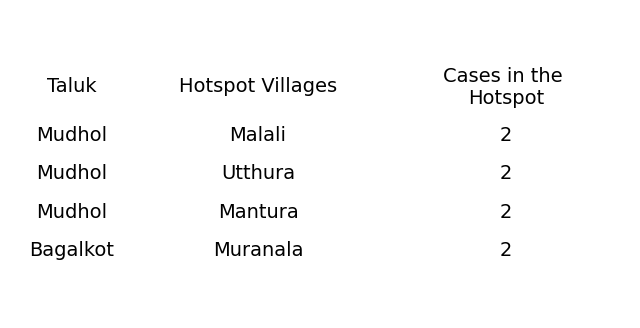

In [248]:

# Extract unique district names
districts = ['Bagalkote']

# Iterate over each district
for district in districts:
    # Filter data for the current district
    table_df_dist = table_df[table_df['District'] == district]
    district_names = table_df_dist['District'].unique()[0]

    # Drop unnecessary columns
    table_df_dist_filtered = table_df_dist.drop(columns=['district_code','District','taluk_code'])

    table_df_dist_filtered = table_df_dist_filtered.rename(columns={
    'Taluk': 'Taluk',
    'Hotspot Villages': 'Hotspot Villages',
    'Cases in the Hotspot': 'Cases in the \nHotspot',
    })

    
    table_df_dist_filtered = table_df_dist_filtered.rename(columns={
        'Taluk': 'Taluk',
        'Hotspot Villages': 'Hotspot Villages',
        'Cases in the Hotspot': 'Cases in the\nHotspot',
    })
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the size as needed

    # Hide the axes
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    # Create a table
    table = ax.table(cellText=table_df_dist_filtered.values,
                     colLabels=table_df_dist_filtered.columns,
                     cellLoc='center', loc='center')

    col_widths = [0.2, 0.4, 0.4]  # Adjust these values based on your data
    for i, width in enumerate(col_widths):
        for j in range(len(table_df_dist_filtered) + 1):  # +1 for the header
            cell = table[j, i]
            cell.set_width(width)
            if j == 0:
                cell.set_height(0.075)  # Adjust the header height as needed
            else:
                cell.set_height(0.05)  # Adjust the row height as needed

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1, 2.5)  # Adjust scaling as needed

    # Adjust edge color and line width for columns
    cell_dict = table.get_celld()
    for (i, j), cell in cell_dict.items():
        if j == 0:  # Header row
            cell.set_edgecolor('black')
            cell.set_linewidth(0.0)
        elif j == len(table_df_dist_filtered.columns) - 1:  # Bottom line of table
            cell.set_edgecolor('black')
            cell.set_linewidth(0.0)
        else:  # Remove lines for other cells
            cell.set_edgecolor('none')
            cell.set_linewidth(0)

    # Add a top border to the header row
    for i in range(len(table_df_dist_filtered.columns)):
        cell = table[0, i]
        if i == 0 & j == 1:        
            cell.set_edgecolor('black')
            cell.set_linewidth(0.1)
            cell.set_text_props(weight='bold')

    # Add a bottom border to the last row
    for i in range(len(table_df_dist_filtered.columns)):
        cell = table[len(table_df_dist_filtered), i]
        cell.set_edgecolor('black')
        cell.set_linewidth(0.0)

    # Set Sans-Serif font family for all cells
    for key, cell in table.get_celld().items():
        cell.set_text_props(fontfamily='sans-serif')

    # # Save the figure as PNG without displaying it
    # save_fig = f'/path/to/combined_image.png'
    # plt.savefig(save_fig, dpi=300, bbox_inches='tight')

    # # Close the plot to free up memory
    # plt.close(fig)

print("Tables saved successfully.")

,district_code,district,taluk,test_result
0,524,Bagalkote,Bagalkot,6
1,524,Bagalkote,Belagali Town Panchayat,2
2,524,Bagalkote,Jamkhandi,10
3,524,Bagalkote,Kurugodu,1
4,524,Bagalkote,Mudhol,8
5,524,Bagalkote,Sandur,4


In [213]:
districts = table_df['District'].unique()

# districts = ['Bagalkote']

# Iterate over each district
for district in districts:
    # Filter data for the current district
    total_cases_taluk_b = total_cases_taluk[total_cases_taluk['district'] == district]
    district_names = total_cases_taluk_b['district'].unique()[0]
    table_filtered_taluk = total_cases_taluk_b.drop(columns=['district','district_code'])
       
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the size as needed

    # Hide the axes
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    # Create a table
    table = ax.table(cellText=table_filtered_taluk.values,
                     colLabels=table_filtered_taluk.columns,
                     cellLoc='center', loc='center',
                     colWidths=[0.4, 0.15])

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1, 2)  # Adjust scaling as needed

    # Adjust edge color and line width for columns
    cell_dict = table.get_celld()
    for (i, j), cell in cell_dict.items():
        cell.set_edgecolor('black')  # Set edge color for all cells
        cell.set_linewidth(0.5)  # Set line width for all cells

    # Set Sans-Serif font family for all cells
    for key, cell in table.get_celld().items():
        if key[0] == 0:  # Header row
            cell.set_text_props(fontfamily='sans-serif', weight='bold')
        else:  # Data rows
            cell.set_text_props(fontfamily='sans-serif') 

    # Save the figure as PNG without displaying it
    save_fig = f'/Users/artpark/Downloads/karnataka_dengue_hotspots/{district}_taluk_table.png'
    plt.savefig(save_fig, dpi=300, bbox_inches='tight')

    # Close the plot to free up memory
    plt.close(fig)

print("Tables saved successfully.")

Tables saved successfully.


In [212]:
districts = table_df['District'].unique()

# districts = ['Bagalkote']

# Iterate over each district
for district in districts:
    # Filter data for the current district
    total_cases_district_b = total_cases_district[total_cases_district['District'] == district]
    table_filtered_district = total_cases_district_b.drop(columns=['district_code'])
       
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the size as needed

    # Hide the axes
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    # Create a table
    table = ax.table(cellText=table_filtered_district.values,
                     colLabels=table_filtered_district.columns,
                     cellLoc='center', loc='center',
                     colWidths=[0.4, 0.15])

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1, 2)  # Adjust scaling as needed

    # Adjust edge color and line width for columns
    cell_dict = table.get_celld()
    for (i, j), cell in cell_dict.items():
        cell.set_edgecolor('black')  # Set edge color for all cells
        cell.set_linewidth(0.5)  # Set line width for all cells

    # Set Sans-Serif font family for all cells
    for key, cell in table.get_celld().items():
        if key[0] == 0:  # Header row
            cell.set_text_props(fontfamily='sans-serif', weight='bold')
        else:  # Data rows
            cell.set_text_props(fontfamily='sans-serif') 

    # Save the figure as PNG without displaying it
    save_fig = f'/Users/artpark/Downloads/karnataka_dengue_hotspots/{district}_total_table.png'
    plt.savefig(save_fig, dpi=300, bbox_inches='tight')

    # Close the plot to free up memory
    plt.close(fig)

print("Tables saved successfully.")

Tables saved successfully.


In [215]:
from pandas.plotting import table
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
import numpy as np


districts = gdf_hotspots['district_code'].unique()

for district in districts:

    taluk_cases = []
    taluk_sum_df = []
    gdf_dist_wgs84_b = gdf_dist_wgs84[gdf_dist_wgs84['LGD_Distri']== district]
    gdf_taluk_wgs84_b = gdf_taluk_wgs84[gdf_taluk_wgs84['district_code']==district]
    gdf_wgs84_b = gdf_wgs84_a[gdf_wgs84_a['district_code']==district]
    
    district_name = gdf_dist_wgs84_b['KGISDist_1'].iloc[0] 
    x_min, y_min, x_max, y_max = gdf_dist_wgs84_b.total_bounds

    table_df_dist = table_df[table_df['district_code'] == district]
    taluk_sum_df = table_df_dist.groupby(['taluk_code'])['Cases'].sum().reset_index()
    taluk_cases = pd.merge(taluk_sum_df, gdf_taluk_wgs84, left_on='taluk_code', right_on='LGD_TalukC', how='inner')

    table_df_dist = table_df[table_df['district_code'] == district]
    table_df_dist = table_df_dist.reset_index(drop=True)
    table_df_dist['Cases']=table_df_dist['Cases'].astype(int)
    
    gdf_hotspots_dist = gdf_hotspots[gdf_hotspots['district_code'] == district]
    gdf_hotspots_dist= gdf_hotspots_dist.reset_index(drop=True)
    gdf_hotspots_dist['centroid_longitude'] = gdf_hotspots_dist['centroid_longitude'].astype(float)
    gdf_hotspots_dist['centroid_latitude'] = gdf_hotspots_dist['centroid_latitude'].astype(float)
     
    
    fig = plt.figure(figsize=(16, 8))
    gs = GridSpec(2, 1, figure=fig, height_ratios=[3, 1])  # More space for the plot, less for the table

    ax_map = fig.add_subplot(gs[0])

    gdf_wgs84_b.plot(ax=ax_map, color='white', edgecolor=(0.4, 0.4, 0.4), 
                        alpha=0.5, linewidth=0.5)  

    gdf_taluk_wgs84_b.plot(ax=ax_map, color='white', edgecolor=(0.0, 0.8, 0.8), 
                        alpha=0.5, linewidth=0.7)

    
    cases_min = taluk_cases['Cases'].min()
    cases_max = taluk_cases['Cases'].max()
    ratio = (cases_max - cases_min) / 4
    norm = Normalize(vmin=cases_min, vmax=cases_max)

    colors = [   # Lightest color with transparency
          (254/255, 230/255, 206/255, 0.8),   # Light color with transparency
          (253/255, 208/255, 162/255, 0.8),   # Medium color with transparency
          (253/255, 174/255, 107/255, 0.8),   # Darker color with transparency
          (253/255, 141/255, 60/255, 0.8)]
    
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=4)

    for idx, row in taluk_cases.iterrows():
        cases = row['Cases']
        color = cmap(norm(cases))
        gdf_taluk_wgs84_b.loc[gdf_taluk_wgs84['LGD_TalukC'] == row['LGD_TalukC']].plot(ax= ax_map, color=color, edgecolor=(0.0, 0.8, 0.8), 
                        alpha=0.7)
        
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax= ax_map, orientation='vertical', shrink=0.8)

    ticks = [cases_min + (i * (cases_max - cases_min) / 4) for i in range(5)]
    tick_labels = [f'{int(t)}' for t in ticks]  
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(tick_labels)
    cbar.ax.tick_params(labelsize=14)

    pos = ax_map.get_position()
    left, bottom, width, height = pos.x0, pos.y0, pos.width, pos.height
    cbar.ax.set_position([left + width + 0.02, bottom, 0.02, height])  # [left, bottom, width, height]

    from_date = df['test_date'].min()
    to_date = df['test_date'].max()
    ax_map.set_title(f'Dengue Hotspots for {district_name} \n {from_date} to {to_date}',fontsize=16)

    for idx, row in gdf_taluk_wgs84_b.iterrows():
        
        taluk_name = row['KGISTalukN']  
        x, y = row.geometry.centroid.x, row.geometry.centroid.y  
        ax_map.plot(x, y, marker='*', markersize=3, markerfacecolor='none', markeredgecolor=(0, 0, 0, 0.5))

        ax_map.annotate(taluk_name, xy=(x, y), xytext=(3, 3), 
                textcoords='offset points', fontsize=7, 
                color=(0, 0, 0, 0.8),ha='center')
    
    gdf_dist_wgs84_b.plot(ax=ax_map, color='white', edgecolor=(0.3, 0.3, 0.8), 
                        alpha=0.5, linewidth=1)  # Adjust linewidth as needed

    bubble_size = table_df_dist['Cases'] * 16
    ax_map.scatter(gdf_hotspots_dist['centroid_longitude'], gdf_hotspots_dist['centroid_latitude'], color=(1, 0.2, 0.2), 
           s=bubble_size, alpha=0.6,label='Hotspots')
    
    # legend = ax_map.legend()
    # legend.get_frame().set_linewidth(.5)
    # legend.get_frame().set_facecolor('none')
    
    ax_map.set_xlim(x_min, x_max)
    ax_map.set_ylim(y_min, y_max)

    save_fig = f'/Users/artpark/Downloads/karnataka_dengue_hotspots/{district_name}_hotspots_map.png'
    plt.savefig(save_fig, dpi=300, bbox_inches='tight')
    plt.close(fig)


<Axes: >

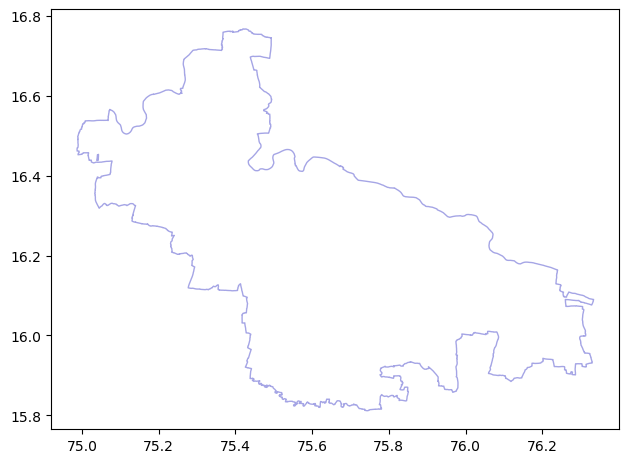

In [72]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 1, figure=fig, height_ratios=[3, 1])  # More space for the plot, less for the table

ax_map = fig.add_subplot(gs[0])

# gdf_wgs84.plot(ax=ax_map, color='white', edgecolor=(0.4, 0.4, 0.4), 
#                         alpha=0.6, linewidth=0.7) 

gdf_dist_wgs84_b.plot(ax=ax_map, color='white', edgecolor=(0.3, 0.3, 0.8), 
                        alpha=0.5, linewidth=1)  # Adjust linewidth as needed




In [85]:
gdf_wgs84

,KGISVillag,KGISVill_1,KGISVill_2,KGISHobliI,UniqueVill,Bhucode,CensusVill,BhoomiVill,created_us,created_da,...,LGDGPCode,LGDGPCode_,Category,LGD_Villag,SHAPE_STAr,SHAPE_STLe,geometry,centroid,centroid_longitude,centroid_latitude
0,5108,3106030001,Boodhanuru,342,3106030001_1,120101001001,2956505496604592,3106030001,SA,2019-04-23,...,216145,None,Cadastral data available and has bhoomi linkage,604592,1.654920e+07,19948.565182,"POLYGON ((75.75912 14.88380, 75.75925 14.88314...",POINT (75.74318 14.85820),75.743182,14.858199
1,5109,3106030002,Byalahunasi,342,3106030002_1,120101001002,2956505496604585,3106030002,SA,2019-04-23,...,216160,None,Cadastral data available and has bhoomi linkage,604585,5.459134e+06,9461.716763,"POLYGON ((75.71619 14.92712, 75.71611 14.92712...",POINT (75.70686 14.93759),75.706855,14.937595
2,5111,3106030004,Dombarahalli,342,3106030004_1,120101001004,2956505496604595,3106030004,SA,2019-04-23,...,216162,None,Cadastral data available and has bhoomi linkage,604595,5.680041e+06,14343.813196,"POLYGON ((75.74970 14.80347, 75.74824 14.80333...",POINT (75.72949 14.81189),75.729486,14.811888
3,5112,3106030005,Haravi,342,3106030005_1,120101001005,2956505496604601,3106030005,SA,2019-04-23,...,216157,None,Cadastral data available and has bhoomi linkage,604601,1.137437e+07,15160.944042,"POLYGON ((75.75657 14.74642, 75.75657 14.74638...",POINT (75.72737 14.73543),75.727368,14.735425
4,5113,3106030005,Haravi,342,3106030005_2,120101001005,2956505496604600,3106030005,SA,2019-04-23,...,216157,None,Cadastral data available and has bhoomi linkage,604601,4.741930e+05,3285.655174,"POLYGON ((75.71982 14.74984, 75.71996 14.75013...",POINT (75.72417 14.75237),75.724170,14.752369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31505,293,2955605444598506,Heggura,41,2955605444598506_1,020201002020,2955605444598506,None,None,None,...,273103,None,Cadastral data available and has no bhoomi data,598506,3.461678e+06,10766.634799,"POLYGON ((75.77610 16.37995, 75.77601 16.37921...",POINT (75.75991 16.37239),75.759915,16.372394
31506,263,2955605444598507,Lingapura.S.R,41,2955605444598507_1,020201001023,2955605444598507,None,None,None,...,273103,None,Cadastral data available and has no bhoomi data,598507,3.656133e+06,9243.382473,"POLYGON ((75.78697 16.37555, 75.78617 16.37442...",POINT (75.77180 16.36810),75.771799,16.368100
31507,420,0208030017,Hirekodagal,391,0208030017_2,020601003023,2955605448599021,0208030017,SURESHBV1,2023-08-17,...,215236,None,Cadastral data available and has bhoomi linkage,599021,1.406198e+07,39361.430733,"POLYGON ((76.15985 15.95959, 76.15990 15.95944...",POINT (76.14802 15.92813),76.148016,15.928130
31508,533,0210030001,Theradhala,967,0210030001_1,020101003021,2955605443598403,0209030001,SURESHBV1,2023-08-17,...,215261,None,Cadastral data available and has bhoomi linkage,598403,5.245609e+07,43284.148390,"POLYGON ((75.06696 16.53913, 75.06696 16.53911...",POINT (75.03706 16.50700),75.037059,16.507001


In [13]:


gdf_hotspots_dist['centroid_longitude'] = gdf_hotspots_dist['centroid_longitude'].astype(float)
gdf_hotspots_dist['centroid_latitude'] = gdf_hotspots_dist['centroid_latitude'].astype(float)

bubble_size = np.array(table_df['Cases']) * 16
ax_map.scatter(gdf_hotspots['centroid_longitude'], gdf_hotspots['centroid_latitude'], color=(1, 0.2, 0.2), 
           s=bubble_size, alpha=0.6,label='Hotspots')

/var/folders/gf/g2c78q9n67ldbc97nhdg_mmh0000gn/T/ipykernel_88145/2035004776.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_hotspots_dist['centroid_longitude'] = gdf_hotspots_dist['centroid_longitude'].astype(float)
/var/folders/gf/g2c78q9n67ldbc97nhdg_mmh0000gn/T/ipykernel_88145/2035004776.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_hotspots_dist['centroid_latitude'] = gdf_hotspots_dist['centroid_latitude'].astype(float)
